## Trial-based (epochs-level) decoding in sensor space

In [1]:
from pathlib import Path
import numpy as np

import mne

mne.set_log_level(verbose='WARNING')


subjects = [
    '04', '06', '07','08', '09', '13','14','15','16','18','19',
    '20','21','22','23','24','25','26','27','28','29','30','32'
]

contrast = ['Cond == 2', 'Cond == 4']


N_JOBS = 7


def read_cleaned_epochs(subject):
    # Import epochs
    meg_subject_dir = Path(f'lb_analysis_sparse/import_metadata/sub-{subject}/meg/')
    filename = f'sub-{subject}_task-sparse_metadata_proc-clean_epo.fif'
    epochs_path = meg_subject_dir / filename

    epochs = mne.read_epochs(epochs_path)
    return epochs


def get_epochs_to_contrast(epochs):
    metadata_query = f'{contrast[0]} or {contrast[1]}'
    epochs_to_contrast = epochs[metadata_query]

    # The data was Maxwell-filtered, so gradiometers and magnetometers are
    # correlated and, therefore, practically contain the "same" information.
    # We can therefore use magnetometers only, which will speed up processing
    # as there's only 1/3rd of the number of sensors compared to gradiometers.
    epochs_to_contrast.pick_types(meg='mag')

    return epochs_to_contrast


%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
from pqdm.processes import pqdm

from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from mne.decoding import Scaler, Vectorizer


def trial_based_decoding(subject):
    epochs = read_cleaned_epochs(subject)
    epochs_to_contrast = get_epochs_to_contrast(epochs)
    X = epochs_to_contrast.copy().crop(0.05, None).get_data()
    y = epochs_to_contrast.metadata['Cond']

    classification_pipeline = make_pipeline(
        Scaler(
            info=epochs_to_contrast.info,
            scalings='mean'
        ),
        Vectorizer(),  # So we can pass the Scaler() results to scikit-learn
        LogisticRegression(solver='liblinear')
    )

    # Now, actually run the classification, and evaluate it via a cross-validation
    # procedure.
    scores = cross_val_score(
        classification_pipeline,
        X,
        y,
        cv=5,
        n_jobs=N_JOBS
    )
    return scores


decoding_scores_all_subjects = pqdm(
    subjects, trial_based_decoding, n_jobs=1
)

  0%|          | 0/23 [00:00<?, ?it/s]

### Looking at decoding performance

In [3]:
print(len(decoding_scores_all_subjects))
print(decoding_scores_all_subjects[3])

23
[0.83373111 0.85043755 0.85429936 0.85111465 0.82643312]


In [4]:
decoding_scores_all_subjects_mean = np.mean(decoding_scores_all_subjects, axis=1)
decoding_scores_all_subjects_mean

array([0.8424436 , 0.83557842, 0.83115016, 0.84320316, 0.84457861,
       0.85337873, 0.83577434, 0.85066927, 0.85263158, 0.85108086,
       0.83399123, 0.83594309, 0.84013878, 0.84814422, 0.85189024,
       0.85540293, 0.84594341, 0.82796931, 0.84698109, 0.83768457,
       0.84442914, 0.8286996 , 0.83573718])

### Visualizing decoding performance

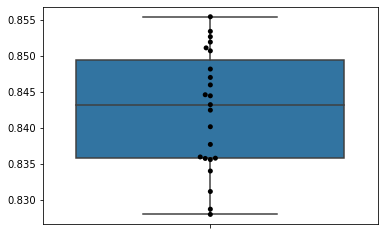

In [5]:
import seaborn as sns

ax = sns.boxplot(y=decoding_scores_all_subjects_mean)
ax = sns.swarmplot(y=decoding_scores_all_subjects_mean, color='black')

## Common Spatial Patterns (CSP) approach

In [6]:
# We will train the classifier on all left visual vs auditory trials on MEG
from sklearn.decomposition import PCA

from mne.decoding import Scaler, Vectorizer, CSP, UnsupervisedSpatialFilter



def run_trial_decoding_csp(subject):
    # Prepare the data
    epochs = read_cleaned_epochs(subject)
    epochs_to_contrast = get_epochs_to_contrast(epochs)
    X = epochs_to_contrast.copy().crop(0.05, None).get_data()
    y = epochs_to_contrast.metadata['Cond']

    classification_pipeline = make_pipeline(
        Scaler(
            info=epochs_to_contrast.info,
            scalings='mean'
        ),
        UnsupervisedSpatialFilter(
            PCA(n_components=60)  # reduce dimensionality
        ),
        CSP(n_components=4, log=True),  # Fit 4 patterns
        LogisticRegression(solver='liblinear')
    )

    # Now, actually run the classification, and evaluate it via a cross-validation
    # procedure.
    scores = cross_val_score(
        classification_pipeline,
        X,
        y,
        cv=5,
        n_jobs=5
    )
    return scores


decoding_scores_all_subjects_csp = pqdm(
    subjects, run_trial_decoding_csp, n_jobs=1
)

  0%|          | 0/23 [00:00<?, ?it/s]

Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 18 (2.2e-16 eps * 60 dim * 1.3e+15  max singular value)
    Using tolerance 18 (2.2e-16 eps * 60 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
    Using tolerance 18 (2.2e-16 eps * 60 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
    Using tolerance 18 (2.2e-16 eps * 60 dim * 1.3e+15  max singular value)
    Estimated rank (mag): 60
    MAG: rank 60 computed from 60 data channels with 0 projectors
Reducing data rank from 60 -> 60
Estimating covariance using EMPIRICAL
Reducing data rank from 60 -> 60
Estimating c

In [7]:
decoding_scores_all_subjects_csp_mean = np.mean(decoding_scores_all_subjects_csp, axis=1)
decoding_scores_all_subjects_csp_mean

array([0.91627209, 0.91745377, 0.91533546, 0.91945247, 0.91701295,
       0.92014067, 0.90230831, 0.92093476, 0.91770335, 0.91897518,
       0.90942982, 0.91653346, 0.91686696, 0.91474019, 0.92043464,
       0.92293047, 0.91969994, 0.91072711, 0.92447058, 0.9203203 ,
       0.91469284, 0.91722596, 0.91217949])

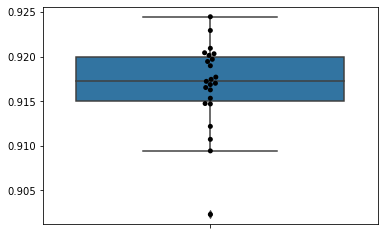

In [8]:
ax = sns.boxplot(y=decoding_scores_all_subjects_csp_mean)
ax = sns.swarmplot(y=decoding_scores_all_subjects_csp_mean, color='black')

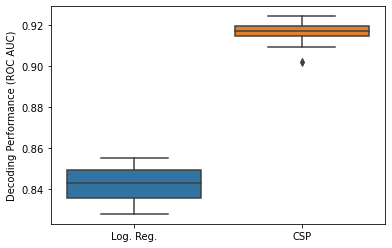

In [11]:
import pandas as pd

scores_df = pd.DataFrame(
    {
        'Log. Reg.': decoding_scores_all_subjects_mean,
        'CSP': decoding_scores_all_subjects_csp_mean
     }
)
ax = sns.boxplot(data=scores_df);
ax.set_ylabel('Decoding Performance (ROC AUC)');